In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np


df = pd.read_csv('./data/df.csv',sep=',')
df  = df.sort_values(by='time',ascending=True).reset_index(drop=True)

BATCHSIZE = 256
LOOKBACK = 100


date = ["2024-02-19",
"2024-03-15",
"2024-04-19",
"2024-05-17",
"2024-06-21",
"2024-07-19",
"2024-08-16",
"2024-09-20",
"2024-10-18",
"2024-11-15",
"2024-12-20",
"2025-01-17"]
df.head()

df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['date'] = df['date'].astype(str)
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute 
# for i in range(1,5):
#     df[f'spread_shift_{i}'] = df.groupby(['hour','minute'])['spread'].shift(i)

df['Expiration_Date'] = df['date'].apply(lambda x: 1 if x in date else 0)
# df.fillna(0,inplace=True)


df.dropna(inplace=True)

df.head()


,time,IF00_close,IF01_close,spread,date,hour,minute,Expiration_Date
0,2024-01-24 09:30:00,3240.0,3236.8,-3.2,2024-01-24,9,30,0
1,2024-01-24 09:31:00,3241.4,3243.0,1.6,2024-01-24,9,31,0
2,2024-01-24 09:32:00,3240.0,3243.0,3.0,2024-01-24,9,32,0
3,2024-01-24 09:33:00,3234.4,3235.6,1.2,2024-01-24,9,33,0
4,2024-01-24 09:34:00,3235.8,3236.0,0.2,2024-01-24,9,34,0


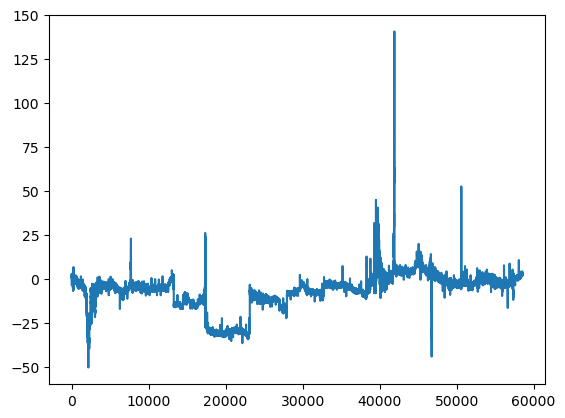

In [8]:
timeseries = df[["spread"]].values.astype('float32')

plt.plot(timeseries[:,0])
plt.show()

In [9]:
# train-test split for time series



import torch

def create_dataset(dataset, lookback,split_index):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """


    X_train, y_train = [], []
    X_test, y_test = [], []
    for i in range(len(dataset)-lookback):
        if i < split_index:
            feature = dataset[i:i+lookback]
            target = dataset[i+lookback:i+lookback+1][:,0:1]
            X_train.append(feature)
            y_train.append(target)
        else:
            feature = dataset[i:i+lookback]
            target = dataset[i+lookback:i+lookback+1][:,0:1]
            X_test.append(feature)
            y_test.append(target)
    # X = np.array(X)
    # y = np.array(y)
    return torch.tensor(X_train), torch.tensor(y_train),torch.tensor(X_test), torch.tensor(y_test)





In [10]:
import torch
import torch.nn as nn
import numpy as np

class CNN(nn.Module):
    def __init__(self, window_size=5):
        super().__init__()
        # 使用大窗口卷积捕获低频趋势
        self.trend_extractor = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=window_size, padding='same'),
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=window_size, padding='same')
        )
        
    def forward(self, x):
        # 输入形状: (batch_size, seq_len)
        x = x.permute(0,2,1)  # 添加通道维度 -> (B, 1, T)
        # print(x.shape)
        trend = self.trend_extractor(x)  # (B, 1, T)
        # residual = x - trend
        return trend

# # 使用示例
# model = DeepTrendDecomposer(window_size=7)
# input_seq = torch.randn(32, 100)  # batch_size=32, seq_len=100
# trend, residual = model(input_seq)


In [11]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        """
        Early stopping to stop the training when the loss does not improve after
        certain epochs.
        
        Args:
            patience (int): How many epochs to wait before stopping when loss is
                           not improving
            min_delta (float): Minimum change in the monitored quantity to
                             qualify as an improvement
            verbose (bool): If True, prints a message for each validation loss improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        
    def __call__(self, val_loss, model, optimizer, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, optimizer, epoch)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, optimizer, epoch)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model, optimizer, epoch):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [12]:
# train-test split for time series



import torch

def create_dataset(dataset, lookback,split_index):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """


    X_train, y_train = [], []
    X_test, y_test = [], []
    for i in range(len(dataset)-lookback):
        if i < split_index:
            feature = dataset[i:i+lookback]
            target = dataset[i+lookback:i+lookback+1][:,0:1]
            X_train.append(feature)
            y_train.append(target)
        else:
            feature = dataset[i:i+lookback]
            target = dataset[i+lookback:i+lookback+1][:,0:1]
            X_test.append(feature)
            y_test.append(target)
    # X = np.array(X)
    # y = np.array(y)
    return torch.tensor(X_train), torch.tensor(y_train),torch.tensor(X_test), torch.tensor(y_test)





In [18]:


class CNNLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super().__init__()
        self.decomposer =  CNN(window_size=7)
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)


    def forward(self, x):
        # 分解趋势
        trend = self.decomposer(x)
        # print(trend.shape,residual.shape)
        
        # 用LSTM预测残差
        trend = trend.permute(0,2,1)
        # residual = residual.permute(0,2,1)
        # residual = residual.unsqueeze(-1)  # (B, T, 1)
        lstm_out, _ = self.lstm(trend)
        pred_trend = self.linear(lstm_out[:, -1, :])
        
        # 预测趋势（简单移动平均）
        # pred_trend = trend[:, -1].unsqueeze(-1)  # 假设趋势缓慢变化
        
        return pred_trend
# model = TrendAwareLSTM().to(device)
# model 

# sum(para.numel() for para in model.parameters())

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNLSTM().to(device)
model 

sum(para.numel() for para in model.parameters())

10892

In [20]:
device

device(type='cuda')

In [21]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import time 
begin_time = time.time()
df_result = pd.DataFrame()

for split_index in range(39237,len(timeseries),100): #, len(timeseries)
    train_size = split_index # 
    # test_size = len(timeseries) - train_size
    # train, test = timeseries[:train_size], timeseries[train_size:]
    lookback = LOOKBACK 
    X_train_all, y_train_all,X_test, y_test = create_dataset(timeseries, lookback=lookback,split_index=split_index)
    # X_test, y_test = create_dataset(test, lookback=lookback)
    print(X_train_all.shape, y_train_all.shape)
    print(X_test.shape, y_test.shape)

    indices = np.arange(len(X_train_all))   
    np.random.shuffle(indices)
    train_val_size = int(len(X_train_all) * 0.8)
    train_indices = indices[:train_val_size]
    val_indices = indices[train_val_size:]
    X_train = X_train_all[train_indices]
    y_train = y_train_all[train_indices]
    X_val = X_train_all[val_indices]
    y_val = y_train_all[val_indices]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    model = CNNLSTM().to(device)
    model 


    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCHSIZE)
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)
    n_epochs = 1000
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            # print(X_batch.shape)
            # X_batch = X_batch.to(device)
            # y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            y_pred_val = model(X_val)
            # print(y_pred.shape,y_batch.shape)
            loss_train = loss_fn(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        # Validation
        loss_val = loss_fn(y_pred_val, y_val)
        early_stopping(loss_val, model, optimizer, epoch)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.eval()
    with torch.no_grad():
        # X_train = X_train.to(device)
        # y_train = y_train.to(device)
        y_pred_train = model(X_train)
        # X_test = X_test.to(device)
        # y_test = y_test.to(device)
        train_rmse = torch.sqrt(loss_fn(y_pred_train, y_train))
        y_pred_test = model(X_test)
        test_rmse = torch.sqrt(loss_fn(y_pred_test, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    end_time = time.time()
    print(f"训练时间: {end_time - begin_time} 秒")

    predict_value = model(X_test[0,:,:].unsqueeze(0))
    predict_value = predict_value.detach().cpu().numpy().flatten()


    df_result_tmp = pd.DataFrame([[split_index, predict_value[0],y_test[0].flatten().cpu().numpy()[0]]],columns=['split_index','predict','true'])
    df_result_tmp
    # df_result = pd.concat([df_result,df_result_tmp],ignore_index=True)
    df_result_tmp.to_csv(f'./data/cnn_lstm_result_{LOOKBACK}.csv',index=False,mode='a')
    
    del model
    del optimizer
    del loader
    del early_stopping
    del X_train
    del y_train
    del X_train_all
    del y_train_all
    del X_val
    del y_val
    del X_test
    del y_test
    del y_pred_train
    del y_pred_test
    del y_pred_val
    del y_pred
    del y_batch
    del X_batch
    torch.cuda.empty_cache()
    

torch.Size([39237, 100, 1]) torch.Size([39237, 1, 1])
torch.Size([19226, 100, 1]) torch.Size([19226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([256, 1, 1])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([157, 1, 1])) that is different to the input size (torch.Size([157, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7848, 1, 1])) that is different to the input size (torch.Size([7848, 1])). This will likely lead to incorrect results due to broadcasting. Please ensur

Early stopping
Epoch 37: train RMSE 9.2846, test RMSE 13.5237
训练时间: 51.36898446083069 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([31389, 1, 1])) that is different to the input size (torch.Size([31389, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([19226, 1, 1])) that is different to the input size (torch.Size([19226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([39337, 100, 1]) torch.Size([39337, 1, 1])
torch.Size([19126, 100, 1]) torch.Size([19126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([237, 1, 1])) that is different to the input size (torch.Size([237, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7868, 1, 1])) that is different to the input size (torch.Size([7868, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 73: train RMSE 9.3032, test RMSE 13.4744
训练时间: 142.09336948394775 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([31469, 1, 1])) that is different to the input size (torch.Size([31469, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([19126, 1, 1])) that is different to the input size (torch.Size([19126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([39437, 100, 1]) torch.Size([39437, 1, 1])
torch.Size([19026, 100, 1]) torch.Size([19026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([61, 1, 1])) that is different to the input size (torch.Size([61, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7888, 1, 1])) that is different to the input size (torch.Size([7888, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 17: train RMSE 9.3185, test RMSE 13.7119
训练时间: 170.09174513816833 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([31549, 1, 1])) that is different to the input size (torch.Size([31549, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([19026, 1, 1])) that is different to the input size (torch.Size([19026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([39537, 100, 1]) torch.Size([39537, 1, 1])
torch.Size([18926, 100, 1]) torch.Size([18926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([141, 1, 1])) that is different to the input size (torch.Size([141, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7908, 1, 1])) that is different to the input size (torch.Size([7908, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 25: train RMSE 9.3141, test RMSE 13.4204
训练时间: 207.30083060264587 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([31629, 1, 1])) that is different to the input size (torch.Size([31629, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18926, 1, 1])) that is different to the input size (torch.Size([18926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([39637, 100, 1]) torch.Size([39637, 1, 1])
torch.Size([18826, 100, 1]) torch.Size([18826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([221, 1, 1])) that is different to the input size (torch.Size([221, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7928, 1, 1])) that is different to the input size (torch.Size([7928, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 37: train RMSE 9.3868, test RMSE 13.4176
训练时间: 257.96271204948425 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([31709, 1, 1])) that is different to the input size (torch.Size([31709, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18826, 1, 1])) that is different to the input size (torch.Size([18826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([39737, 100, 1]) torch.Size([39737, 1, 1])
torch.Size([18726, 100, 1]) torch.Size([18726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([45, 1, 1])) that is different to the input size (torch.Size([45, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7948, 1, 1])) that is different to the input size (torch.Size([7948, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 28: train RMSE 9.5548, test RMSE 13.1508
训练时间: 298.88357853889465 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([31789, 1, 1])) that is different to the input size (torch.Size([31789, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18726, 1, 1])) that is different to the input size (torch.Size([18726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([39837, 100, 1]) torch.Size([39837, 1, 1])
torch.Size([18626, 100, 1]) torch.Size([18626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([125, 1, 1])) that is different to the input size (torch.Size([125, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7968, 1, 1])) that is different to the input size (torch.Size([7968, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 30: train RMSE 9.6607, test RMSE 12.9470
训练时间: 341.8755896091461 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([31869, 1, 1])) that is different to the input size (torch.Size([31869, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18626, 1, 1])) that is different to the input size (torch.Size([18626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([39937, 100, 1]) torch.Size([39937, 1, 1])
torch.Size([18526, 100, 1]) torch.Size([18526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([205, 1, 1])) that is different to the input size (torch.Size([205, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7988, 1, 1])) that is different to the input size (torch.Size([7988, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 18: train RMSE 9.6974, test RMSE 12.8526
训练时间: 370.93912839889526 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([31949, 1, 1])) that is different to the input size (torch.Size([31949, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18526, 1, 1])) that is different to the input size (torch.Size([18526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([40037, 100, 1]) torch.Size([40037, 1, 1])
torch.Size([18426, 100, 1]) torch.Size([18426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29, 1, 1])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8008, 1, 1])) that is different to the input size (torch.Size([8008, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 19: train RMSE 9.7226, test RMSE 12.6466
训练时间: 400.9401457309723 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32029, 1, 1])) that is different to the input size (torch.Size([32029, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18426, 1, 1])) that is different to the input size (torch.Size([18426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([40137, 100, 1]) torch.Size([40137, 1, 1])
torch.Size([18326, 100, 1]) torch.Size([18326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([109, 1, 1])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8028, 1, 1])) that is different to the input size (torch.Size([8028, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 33: train RMSE 9.7070, test RMSE 12.7551
训练时间: 446.18797063827515 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32109, 1, 1])) that is different to the input size (torch.Size([32109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18326, 1, 1])) that is different to the input size (torch.Size([18326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([40237, 100, 1]) torch.Size([40237, 1, 1])
torch.Size([18226, 100, 1]) torch.Size([18226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([189, 1, 1])) that is different to the input size (torch.Size([189, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8048, 1, 1])) that is different to the input size (torch.Size([8048, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 30: train RMSE 9.7406, test RMSE 12.7924
训练时间: 489.18647360801697 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32189, 1, 1])) that is different to the input size (torch.Size([32189, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18226, 1, 1])) that is different to the input size (torch.Size([18226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([40337, 100, 1]) torch.Size([40337, 1, 1])
torch.Size([18126, 100, 1]) torch.Size([18126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13, 1, 1])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8068, 1, 1])) that is different to the input size (torch.Size([8068, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 87: train RMSE 9.7537, test RMSE 12.6910
训练时间: 596.5782086849213 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32269, 1, 1])) that is different to the input size (torch.Size([32269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18126, 1, 1])) that is different to the input size (torch.Size([18126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([40437, 100, 1]) torch.Size([40437, 1, 1])
torch.Size([18026, 100, 1]) torch.Size([18026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([93, 1, 1])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8088, 1, 1])) that is different to the input size (torch.Size([8088, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 30: train RMSE 9.7179, test RMSE 12.7029
训练时间: 639.4688806533813 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32349, 1, 1])) that is different to the input size (torch.Size([32349, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18026, 1, 1])) that is different to the input size (torch.Size([18026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([40537, 100, 1]) torch.Size([40537, 1, 1])
torch.Size([17926, 100, 1]) torch.Size([17926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([173, 1, 1])) that is different to the input size (torch.Size([173, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8108, 1, 1])) that is different to the input size (torch.Size([8108, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 99: train RMSE 9.7303, test RMSE 12.6989
训练时间: 762.3734652996063 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32429, 1, 1])) that is different to the input size (torch.Size([32429, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17926, 1, 1])) that is different to the input size (torch.Size([17926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([40637, 100, 1]) torch.Size([40637, 1, 1])
torch.Size([17826, 100, 1]) torch.Size([17826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([253, 1, 1])) that is different to the input size (torch.Size([253, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8128, 1, 1])) that is different to the input size (torch.Size([8128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 24: train RMSE 9.7505, test RMSE 12.6150
训练时间: 799.6001241207123 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32509, 1, 1])) that is different to the input size (torch.Size([32509, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17826, 1, 1])) that is different to the input size (torch.Size([17826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([40737, 100, 1]) torch.Size([40737, 1, 1])
torch.Size([17726, 100, 1]) torch.Size([17726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([77, 1, 1])) that is different to the input size (torch.Size([77, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8148, 1, 1])) that is different to the input size (torch.Size([8148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 63: train RMSE 9.7349, test RMSE 12.7440
训练时间: 883.2622518539429 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32589, 1, 1])) that is different to the input size (torch.Size([32589, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17726, 1, 1])) that is different to the input size (torch.Size([17726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([40837, 100, 1]) torch.Size([40837, 1, 1])
torch.Size([17626, 100, 1]) torch.Size([17626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8168, 1, 1])) that is different to the input size (torch.Size([8168, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 37: train RMSE 9.7325, test RMSE 12.8246
训练时间: 935.3542747497559 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32669, 1, 1])) that is different to the input size (torch.Size([32669, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17626, 1, 1])) that is different to the input size (torch.Size([17626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([40937, 100, 1]) torch.Size([40937, 1, 1])
torch.Size([17526, 100, 1]) torch.Size([17526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8188, 1, 1])) that is different to the input size (torch.Size([8188, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 20: train RMSE 9.7476, test RMSE 12.6289
训练时间: 967.6256966590881 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32749, 1, 1])) that is different to the input size (torch.Size([32749, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17526, 1, 1])) that is different to the input size (torch.Size([17526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([41037, 100, 1]) torch.Size([41037, 1, 1])
torch.Size([17426, 100, 1]) torch.Size([17426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8208, 1, 1])) that is different to the input size (torch.Size([8208, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 37: train RMSE 9.7204, test RMSE 12.7547
训练时间: 1017.0932848453522 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32829, 1, 1])) that is different to the input size (torch.Size([32829, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17426, 1, 1])) that is different to the input size (torch.Size([17426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([41137, 100, 1]) torch.Size([41137, 1, 1])
torch.Size([17326, 100, 1]) torch.Size([17326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8228, 1, 1])) that is different to the input size (torch.Size([8228, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 109: train RMSE 9.6989, test RMSE 12.8072
训练时间: 1147.8171288967133 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32909, 1, 1])) that is different to the input size (torch.Size([32909, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17326, 1, 1])) that is different to the input size (torch.Size([17326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([41237, 100, 1]) torch.Size([41237, 1, 1])
torch.Size([17226, 100, 1]) torch.Size([17226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8248, 1, 1])) that is different to the input size (torch.Size([8248, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 71: train RMSE 9.7163, test RMSE 12.5307
训练时间: 1239.6423501968384 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32989, 1, 1])) that is different to the input size (torch.Size([32989, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17226, 1, 1])) that is different to the input size (torch.Size([17226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([41337, 100, 1]) torch.Size([41337, 1, 1])
torch.Size([17126, 100, 1]) torch.Size([17126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8268, 1, 1])) that is different to the input size (torch.Size([8268, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 65: train RMSE 9.7508, test RMSE 12.6331
训练时间: 1323.257831811905 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33069, 1, 1])) that is different to the input size (torch.Size([33069, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17126, 1, 1])) that is different to the input size (torch.Size([17126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([41437, 100, 1]) torch.Size([41437, 1, 1])
torch.Size([17026, 100, 1]) torch.Size([17026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8288, 1, 1])) that is different to the input size (torch.Size([8288, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 49: train RMSE 9.7391, test RMSE 12.5356
训练时间: 1386.2272353172302 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33149, 1, 1])) that is different to the input size (torch.Size([33149, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([17026, 1, 1])) that is different to the input size (torch.Size([17026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([41537, 100, 1]) torch.Size([41537, 1, 1])
torch.Size([16926, 100, 1]) torch.Size([16926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8308, 1, 1])) that is different to the input size (torch.Size([8308, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 151: train RMSE 9.7539, test RMSE 12.6412
训练时间: 1570.8568432331085 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33229, 1, 1])) that is different to the input size (torch.Size([33229, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16926, 1, 1])) that is different to the input size (torch.Size([16926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([41637, 100, 1]) torch.Size([41637, 1, 1])
torch.Size([16826, 100, 1]) torch.Size([16826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8328, 1, 1])) that is different to the input size (torch.Size([8328, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 85: train RMSE 9.7188, test RMSE 12.4706
训练时间: 1680.125170469284 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33309, 1, 1])) that is different to the input size (torch.Size([33309, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16826, 1, 1])) that is different to the input size (torch.Size([16826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([41737, 100, 1]) torch.Size([41737, 1, 1])
torch.Size([16726, 100, 1]) torch.Size([16726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8348, 1, 1])) that is different to the input size (torch.Size([8348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 50: train RMSE 9.7640, test RMSE 12.4191
训练时间: 1747.6886916160583 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33389, 1, 1])) that is different to the input size (torch.Size([33389, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16726, 1, 1])) that is different to the input size (torch.Size([16726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([41837, 100, 1]) torch.Size([41837, 1, 1])
torch.Size([16626, 100, 1]) torch.Size([16626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8368, 1, 1])) that is different to the input size (torch.Size([8368, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 49: train RMSE 10.3159, test RMSE 11.3491
训练时间: 1813.3725607395172 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33469, 1, 1])) that is different to the input size (torch.Size([33469, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16626, 1, 1])) that is different to the input size (torch.Size([16626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([41937, 100, 1]) torch.Size([41937, 1, 1])
torch.Size([16526, 100, 1]) torch.Size([16526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8388, 1, 1])) that is different to the input size (torch.Size([8388, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 20: train RMSE 10.2331, test RMSE 11.3573
训练时间: 1846.2615530490875 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33549, 1, 1])) that is different to the input size (torch.Size([33549, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16526, 1, 1])) that is different to the input size (torch.Size([16526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([42037, 100, 1]) torch.Size([42037, 1, 1])
torch.Size([16426, 100, 1]) torch.Size([16426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8408, 1, 1])) that is different to the input size (torch.Size([8408, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 115: train RMSE 10.2320, test RMSE 11.2189
训练时间: 1989.7342414855957 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33629, 1, 1])) that is different to the input size (torch.Size([33629, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16426, 1, 1])) that is different to the input size (torch.Size([16426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([42137, 100, 1]) torch.Size([42137, 1, 1])
torch.Size([16326, 100, 1]) torch.Size([16326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8428, 1, 1])) that is different to the input size (torch.Size([8428, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 118: train RMSE 10.3316, test RMSE 11.1363
训练时间: 2139.7977209091187 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33709, 1, 1])) that is different to the input size (torch.Size([33709, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16326, 1, 1])) that is different to the input size (torch.Size([16326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([42237, 100, 1]) torch.Size([42237, 1, 1])
torch.Size([16226, 100, 1]) torch.Size([16226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8448, 1, 1])) that is different to the input size (torch.Size([8448, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 63: train RMSE 10.3830, test RMSE 11.1586
训练时间: 2217.044069290161 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33789, 1, 1])) that is different to the input size (torch.Size([33789, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16226, 1, 1])) that is different to the input size (torch.Size([16226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([42337, 100, 1]) torch.Size([42337, 1, 1])
torch.Size([16126, 100, 1]) torch.Size([16126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8468, 1, 1])) that is different to the input size (torch.Size([8468, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 27: train RMSE 10.2334, test RMSE 11.0645
训练时间: 2255.2944808006287 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33869, 1, 1])) that is different to the input size (torch.Size([33869, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16126, 1, 1])) that is different to the input size (torch.Size([16126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([42437, 100, 1]) torch.Size([42437, 1, 1])
torch.Size([16026, 100, 1]) torch.Size([16026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8488, 1, 1])) that is different to the input size (torch.Size([8488, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 127: train RMSE 10.3752, test RMSE 11.0752
训练时间: 2414.8850989341736 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([33949, 1, 1])) that is different to the input size (torch.Size([33949, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16026, 1, 1])) that is different to the input size (torch.Size([16026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([42537, 100, 1]) torch.Size([42537, 1, 1])
torch.Size([15926, 100, 1]) torch.Size([15926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8508, 1, 1])) that is different to the input size (torch.Size([8508, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 40: train RMSE 10.3362, test RMSE 10.9103
训练时间: 2470.1879835128784 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34029, 1, 1])) that is different to the input size (torch.Size([34029, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15926, 1, 1])) that is different to the input size (torch.Size([15926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([42637, 100, 1]) torch.Size([42637, 1, 1])
torch.Size([15826, 100, 1]) torch.Size([15826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8528, 1, 1])) that is different to the input size (torch.Size([8528, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 25: train RMSE 10.3740, test RMSE 11.1814
训练时间: 2508.9679300785065 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34109, 1, 1])) that is different to the input size (torch.Size([34109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15826, 1, 1])) that is different to the input size (torch.Size([15826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([42737, 100, 1]) torch.Size([42737, 1, 1])
torch.Size([15726, 100, 1]) torch.Size([15726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8548, 1, 1])) that is different to the input size (torch.Size([8548, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 25: train RMSE 10.3711, test RMSE 10.6689
训练时间: 2546.653344154358 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34189, 1, 1])) that is different to the input size (torch.Size([34189, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15726, 1, 1])) that is different to the input size (torch.Size([15726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([42837, 100, 1]) torch.Size([42837, 1, 1])
torch.Size([15626, 100, 1]) torch.Size([15626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8568, 1, 1])) that is different to the input size (torch.Size([8568, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 31: train RMSE 10.3101, test RMSE 10.9311
训练时间: 2590.720201730728 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34269, 1, 1])) that is different to the input size (torch.Size([34269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15626, 1, 1])) that is different to the input size (torch.Size([15626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([42937, 100, 1]) torch.Size([42937, 1, 1])
torch.Size([15526, 100, 1]) torch.Size([15526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8588, 1, 1])) that is different to the input size (torch.Size([8588, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 60: train RMSE 10.3218, test RMSE 10.8006
训练时间: 2671.1825778484344 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34349, 1, 1])) that is different to the input size (torch.Size([34349, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15526, 1, 1])) that is different to the input size (torch.Size([15526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([43037, 100, 1]) torch.Size([43037, 1, 1])
torch.Size([15426, 100, 1]) torch.Size([15426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8608, 1, 1])) that is different to the input size (torch.Size([8608, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 41: train RMSE 10.3597, test RMSE 10.8980
训练时间: 2733.0468213558197 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34429, 1, 1])) that is different to the input size (torch.Size([34429, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15426, 1, 1])) that is different to the input size (torch.Size([15426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([43137, 100, 1]) torch.Size([43137, 1, 1])
torch.Size([15326, 100, 1]) torch.Size([15326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8628, 1, 1])) that is different to the input size (torch.Size([8628, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 206: train RMSE 10.3945, test RMSE 10.8448
训练时间: 2995.5092940330505 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34509, 1, 1])) that is different to the input size (torch.Size([34509, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15326, 1, 1])) that is different to the input size (torch.Size([15326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([43237, 100, 1]) torch.Size([43237, 1, 1])
torch.Size([15226, 100, 1]) torch.Size([15226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8648, 1, 1])) that is different to the input size (torch.Size([8648, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 17: train RMSE 10.3456, test RMSE 10.8355
训练时间: 3025.6895904541016 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34589, 1, 1])) that is different to the input size (torch.Size([34589, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15226, 1, 1])) that is different to the input size (torch.Size([15226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([43337, 100, 1]) torch.Size([43337, 1, 1])
torch.Size([15126, 100, 1]) torch.Size([15126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8668, 1, 1])) that is different to the input size (torch.Size([8668, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 22: train RMSE 10.3965, test RMSE 10.6093
训练时间: 3062.1574778556824 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34669, 1, 1])) that is different to the input size (torch.Size([34669, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15126, 1, 1])) that is different to the input size (torch.Size([15126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([43437, 100, 1]) torch.Size([43437, 1, 1])
torch.Size([15026, 100, 1]) torch.Size([15026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8688, 1, 1])) that is different to the input size (torch.Size([8688, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 181: train RMSE 10.3630, test RMSE 10.6426
训练时间: 3292.942089319229 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34749, 1, 1])) that is different to the input size (torch.Size([34749, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15026, 1, 1])) that is different to the input size (torch.Size([15026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([43537, 100, 1]) torch.Size([43537, 1, 1])
torch.Size([14926, 100, 1]) torch.Size([14926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8708, 1, 1])) that is different to the input size (torch.Size([8708, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 25: train RMSE 10.4775, test RMSE 10.5381
训练时间: 3333.760817050934 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34829, 1, 1])) that is different to the input size (torch.Size([34829, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14926, 1, 1])) that is different to the input size (torch.Size([14926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([43637, 100, 1]) torch.Size([43637, 1, 1])
torch.Size([14826, 100, 1]) torch.Size([14826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8728, 1, 1])) that is different to the input size (torch.Size([8728, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 53: train RMSE 10.3251, test RMSE 10.4936
训练时间: 3410.327043533325 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34909, 1, 1])) that is different to the input size (torch.Size([34909, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14826, 1, 1])) that is different to the input size (torch.Size([14826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([43737, 100, 1]) torch.Size([43737, 1, 1])
torch.Size([14726, 100, 1]) torch.Size([14726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8748, 1, 1])) that is different to the input size (torch.Size([8748, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 18: train RMSE 10.4026, test RMSE 10.3788
训练时间: 3442.2040679454803 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([34989, 1, 1])) that is different to the input size (torch.Size([34989, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14726, 1, 1])) that is different to the input size (torch.Size([14726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([43837, 100, 1]) torch.Size([43837, 1, 1])
torch.Size([14626, 100, 1]) torch.Size([14626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8768, 1, 1])) that is different to the input size (torch.Size([8768, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 45: train RMSE 10.4633, test RMSE 10.4713
训练时间: 3509.779349565506 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35069, 1, 1])) that is different to the input size (torch.Size([35069, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14626, 1, 1])) that is different to the input size (torch.Size([14626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([43937, 100, 1]) torch.Size([43937, 1, 1])
torch.Size([14526, 100, 1]) torch.Size([14526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8788, 1, 1])) that is different to the input size (torch.Size([8788, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 38: train RMSE 10.4899, test RMSE 10.4377
训练时间: 3568.5921947956085 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35149, 1, 1])) that is different to the input size (torch.Size([35149, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14526, 1, 1])) that is different to the input size (torch.Size([14526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([44037, 100, 1]) torch.Size([44037, 1, 1])
torch.Size([14426, 100, 1]) torch.Size([14426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8808, 1, 1])) that is different to the input size (torch.Size([8808, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 16: train RMSE 10.4964, test RMSE 10.4287
训练时间: 3596.981456756592 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35229, 1, 1])) that is different to the input size (torch.Size([35229, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14426, 1, 1])) that is different to the input size (torch.Size([14426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([44137, 100, 1]) torch.Size([44137, 1, 1])
torch.Size([14326, 100, 1]) torch.Size([14326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8828, 1, 1])) that is different to the input size (torch.Size([8828, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 12: train RMSE 10.4834, test RMSE 9.9824
训练时间: 3620.7130324840546 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35309, 1, 1])) that is different to the input size (torch.Size([35309, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14326, 1, 1])) that is different to the input size (torch.Size([14326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([44237, 100, 1]) torch.Size([44237, 1, 1])
torch.Size([14226, 100, 1]) torch.Size([14226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8848, 1, 1])) that is different to the input size (torch.Size([8848, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 22: train RMSE 10.4653, test RMSE 10.1234
训练时间: 3656.954792022705 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35389, 1, 1])) that is different to the input size (torch.Size([35389, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14226, 1, 1])) that is different to the input size (torch.Size([14226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([44337, 100, 1]) torch.Size([44337, 1, 1])
torch.Size([14126, 100, 1]) torch.Size([14126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8868, 1, 1])) that is different to the input size (torch.Size([8868, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 48: train RMSE 10.3782, test RMSE 10.0353
训练时间: 3724.4437112808228 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35469, 1, 1])) that is different to the input size (torch.Size([35469, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14126, 1, 1])) that is different to the input size (torch.Size([14126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([44437, 100, 1]) torch.Size([44437, 1, 1])
torch.Size([14026, 100, 1]) torch.Size([14026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8888, 1, 1])) that is different to the input size (torch.Size([8888, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 74: train RMSE 10.4633, test RMSE 9.9478
训练时间: 3827.854554414749 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35549, 1, 1])) that is different to the input size (torch.Size([35549, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([14026, 1, 1])) that is different to the input size (torch.Size([14026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([44537, 100, 1]) torch.Size([44537, 1, 1])
torch.Size([13926, 100, 1]) torch.Size([13926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8908, 1, 1])) that is different to the input size (torch.Size([8908, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 18: train RMSE 10.4531, test RMSE 9.8137
训练时间: 3858.708066701889 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35629, 1, 1])) that is different to the input size (torch.Size([35629, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13926, 1, 1])) that is different to the input size (torch.Size([13926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([44637, 100, 1]) torch.Size([44637, 1, 1])
torch.Size([13826, 100, 1]) torch.Size([13826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8928, 1, 1])) that is different to the input size (torch.Size([8928, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 34: train RMSE 10.5082, test RMSE 9.8656
训练时间: 3909.831611633301 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35709, 1, 1])) that is different to the input size (torch.Size([35709, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13826, 1, 1])) that is different to the input size (torch.Size([13826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([44737, 100, 1]) torch.Size([44737, 1, 1])
torch.Size([13726, 100, 1]) torch.Size([13726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8948, 1, 1])) that is different to the input size (torch.Size([8948, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 25: train RMSE 10.5327, test RMSE 9.6437
训练时间: 3949.4662714004517 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35789, 1, 1])) that is different to the input size (torch.Size([35789, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13726, 1, 1])) that is different to the input size (torch.Size([13726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([44837, 100, 1]) torch.Size([44837, 1, 1])
torch.Size([13626, 100, 1]) torch.Size([13626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8968, 1, 1])) that is different to the input size (torch.Size([8968, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 33: train RMSE 10.6034, test RMSE 9.4520
训练时间: 4001.6802775859833 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35869, 1, 1])) that is different to the input size (torch.Size([35869, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13626, 1, 1])) that is different to the input size (torch.Size([13626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([44937, 100, 1]) torch.Size([44937, 1, 1])
torch.Size([13526, 100, 1]) torch.Size([13526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8988, 1, 1])) that is different to the input size (torch.Size([8988, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 66: train RMSE 10.5779, test RMSE 9.6314
训练时间: 4096.979155540466 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([35949, 1, 1])) that is different to the input size (torch.Size([35949, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13526, 1, 1])) that is different to the input size (torch.Size([13526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([45037, 100, 1]) torch.Size([45037, 1, 1])
torch.Size([13426, 100, 1]) torch.Size([13426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9008, 1, 1])) that is different to the input size (torch.Size([9008, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 22: train RMSE 10.6054, test RMSE 9.2997
训练时间: 4135.328134775162 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36029, 1, 1])) that is different to the input size (torch.Size([36029, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13426, 1, 1])) that is different to the input size (torch.Size([13426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([45137, 100, 1]) torch.Size([45137, 1, 1])
torch.Size([13326, 100, 1]) torch.Size([13326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9028, 1, 1])) that is different to the input size (torch.Size([9028, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 43: train RMSE 10.5967, test RMSE 9.1579
训练时间: 4197.9120836257935 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36109, 1, 1])) that is different to the input size (torch.Size([36109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13326, 1, 1])) that is different to the input size (torch.Size([13326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([45237, 100, 1]) torch.Size([45237, 1, 1])
torch.Size([13226, 100, 1]) torch.Size([13226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9048, 1, 1])) that is different to the input size (torch.Size([9048, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 45: train RMSE 10.6442, test RMSE 8.9625
训练时间: 4264.638179063797 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36189, 1, 1])) that is different to the input size (torch.Size([36189, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13226, 1, 1])) that is different to the input size (torch.Size([13226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([45337, 100, 1]) torch.Size([45337, 1, 1])
torch.Size([13126, 100, 1]) torch.Size([13126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9068, 1, 1])) that is different to the input size (torch.Size([9068, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 32: train RMSE 10.7134, test RMSE 8.7454
训练时间: 4316.069841146469 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36269, 1, 1])) that is different to the input size (torch.Size([36269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13126, 1, 1])) that is different to the input size (torch.Size([13126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([45437, 100, 1]) torch.Size([45437, 1, 1])
torch.Size([13026, 100, 1]) torch.Size([13026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9088, 1, 1])) that is different to the input size (torch.Size([9088, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 21: train RMSE 10.7464, test RMSE 8.7436
训练时间: 4351.581663608551 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36349, 1, 1])) that is different to the input size (torch.Size([36349, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13026, 1, 1])) that is different to the input size (torch.Size([13026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([45537, 100, 1]) torch.Size([45537, 1, 1])
torch.Size([12926, 100, 1]) torch.Size([12926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9108, 1, 1])) that is different to the input size (torch.Size([9108, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 39: train RMSE 10.8215, test RMSE 8.4651
训练时间: 4409.267937421799 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36429, 1, 1])) that is different to the input size (torch.Size([36429, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12926, 1, 1])) that is different to the input size (torch.Size([12926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([45637, 100, 1]) torch.Size([45637, 1, 1])
torch.Size([12826, 100, 1]) torch.Size([12826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9128, 1, 1])) that is different to the input size (torch.Size([9128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 12: train RMSE 10.7631, test RMSE 8.2548
训练时间: 4434.408545017242 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36509, 1, 1])) that is different to the input size (torch.Size([36509, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12826, 1, 1])) that is different to the input size (torch.Size([12826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([45737, 100, 1]) torch.Size([45737, 1, 1])
torch.Size([12726, 100, 1]) torch.Size([12726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9148, 1, 1])) that is different to the input size (torch.Size([9148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 89: train RMSE 10.6946, test RMSE 8.3791
训练时间: 4559.136672973633 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36589, 1, 1])) that is different to the input size (torch.Size([36589, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12726, 1, 1])) that is different to the input size (torch.Size([12726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([45837, 100, 1]) torch.Size([45837, 1, 1])
torch.Size([12626, 100, 1]) torch.Size([12626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9168, 1, 1])) that is different to the input size (torch.Size([9168, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 26: train RMSE 10.7689, test RMSE 8.2469
训练时间: 4598.687024354935 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36669, 1, 1])) that is different to the input size (torch.Size([36669, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12626, 1, 1])) that is different to the input size (torch.Size([12626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([45937, 100, 1]) torch.Size([45937, 1, 1])
torch.Size([12526, 100, 1]) torch.Size([12526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9188, 1, 1])) that is different to the input size (torch.Size([9188, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 25: train RMSE 10.7681, test RMSE 7.9787
训练时间: 4637.717787504196 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36749, 1, 1])) that is different to the input size (torch.Size([36749, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12526, 1, 1])) that is different to the input size (torch.Size([12526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([46037, 100, 1]) torch.Size([46037, 1, 1])
torch.Size([12426, 100, 1]) torch.Size([12426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9208, 1, 1])) that is different to the input size (torch.Size([9208, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 199: train RMSE 10.8078, test RMSE 8.0267
训练时间: 4904.802038431168 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36829, 1, 1])) that is different to the input size (torch.Size([36829, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12426, 1, 1])) that is different to the input size (torch.Size([12426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([46137, 100, 1]) torch.Size([46137, 1, 1])
torch.Size([12326, 100, 1]) torch.Size([12326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9228, 1, 1])) that is different to the input size (torch.Size([9228, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 45: train RMSE 10.7638, test RMSE 8.0296
训练时间: 4973.075509548187 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36909, 1, 1])) that is different to the input size (torch.Size([36909, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12326, 1, 1])) that is different to the input size (torch.Size([12326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([46237, 100, 1]) torch.Size([46237, 1, 1])
torch.Size([12226, 100, 1]) torch.Size([12226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9248, 1, 1])) that is different to the input size (torch.Size([9248, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 15: train RMSE 10.7101, test RMSE 8.0520
训练时间: 5001.69570350647 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([36989, 1, 1])) that is different to the input size (torch.Size([36989, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12226, 1, 1])) that is different to the input size (torch.Size([12226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([46337, 100, 1]) torch.Size([46337, 1, 1])
torch.Size([12126, 100, 1]) torch.Size([12126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9268, 1, 1])) that is different to the input size (torch.Size([9268, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 13: train RMSE 10.7708, test RMSE 7.8054
训练时间: 5027.279737949371 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37069, 1, 1])) that is different to the input size (torch.Size([37069, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12126, 1, 1])) that is different to the input size (torch.Size([12126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([46437, 100, 1]) torch.Size([46437, 1, 1])
torch.Size([12026, 100, 1]) torch.Size([12026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9288, 1, 1])) that is different to the input size (torch.Size([9288, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37149, 1, 1])) that is different to the input size (torch.Size([37149, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12026, 1, 1])) that is different to the input size (torch.Size([12026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 19: train RMSE 10.7252, test RMSE 7.7865
训练时间: 5061.192409992218 秒
torch.Size([46537, 100, 1]) torch.Size([46537, 1, 1])
torch.Size([11926, 100, 1]) torch.Size([11926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9308, 1, 1])) that is different to the input size (torch.Size([9308, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 144: train RMSE 10.8327, test RMSE 7.8565
训练时间: 5258.124703645706 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37229, 1, 1])) that is different to the input size (torch.Size([37229, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11926, 1, 1])) that is different to the input size (torch.Size([11926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([46637, 100, 1]) torch.Size([46637, 1, 1])
torch.Size([11826, 100, 1]) torch.Size([11826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9328, 1, 1])) that is different to the input size (torch.Size([9328, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 14: train RMSE 10.8427, test RMSE 7.5283
训练时间: 5284.761275529861 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37309, 1, 1])) that is different to the input size (torch.Size([37309, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11826, 1, 1])) that is different to the input size (torch.Size([11826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([46737, 100, 1]) torch.Size([46737, 1, 1])
torch.Size([11726, 100, 1]) torch.Size([11726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9348, 1, 1])) that is different to the input size (torch.Size([9348, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 37: train RMSE 10.7786, test RMSE 7.6862
训练时间: 5343.5125687122345 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37389, 1, 1])) that is different to the input size (torch.Size([37389, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11726, 1, 1])) that is different to the input size (torch.Size([11726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([46837, 100, 1]) torch.Size([46837, 1, 1])
torch.Size([11626, 100, 1]) torch.Size([11626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9368, 1, 1])) that is different to the input size (torch.Size([9368, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 16: train RMSE 10.8565, test RMSE 7.2633
训练时间: 5374.409093379974 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37469, 1, 1])) that is different to the input size (torch.Size([37469, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11626, 1, 1])) that is different to the input size (torch.Size([11626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([46937, 100, 1]) torch.Size([46937, 1, 1])
torch.Size([11526, 100, 1]) torch.Size([11526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9388, 1, 1])) that is different to the input size (torch.Size([9388, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 52: train RMSE 10.8086, test RMSE 7.2183
训练时间: 5451.589675664902 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37549, 1, 1])) that is different to the input size (torch.Size([37549, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11526, 1, 1])) that is different to the input size (torch.Size([11526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([47037, 100, 1]) torch.Size([47037, 1, 1])
torch.Size([11426, 100, 1]) torch.Size([11426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9408, 1, 1])) that is different to the input size (torch.Size([9408, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 26: train RMSE 10.8648, test RMSE 7.1322
训练时间: 5495.795766115189 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37629, 1, 1])) that is different to the input size (torch.Size([37629, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11426, 1, 1])) that is different to the input size (torch.Size([11426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([47137, 100, 1]) torch.Size([47137, 1, 1])
torch.Size([11326, 100, 1]) torch.Size([11326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9428, 1, 1])) that is different to the input size (torch.Size([9428, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 33: train RMSE 10.7990, test RMSE 7.4063
训练时间: 5548.598375082016 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37709, 1, 1])) that is different to the input size (torch.Size([37709, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11326, 1, 1])) that is different to the input size (torch.Size([11326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([47237, 100, 1]) torch.Size([47237, 1, 1])
torch.Size([11226, 100, 1]) torch.Size([11226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9448, 1, 1])) that is different to the input size (torch.Size([9448, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 22: train RMSE 10.8300, test RMSE 7.1769
训练时间: 5588.432336091995 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37789, 1, 1])) that is different to the input size (torch.Size([37789, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11226, 1, 1])) that is different to the input size (torch.Size([11226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([47337, 100, 1]) torch.Size([47337, 1, 1])
torch.Size([11126, 100, 1]) torch.Size([11126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9468, 1, 1])) that is different to the input size (torch.Size([9468, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 29: train RMSE 10.8156, test RMSE 7.0044
训练时间: 5635.293959379196 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37869, 1, 1])) that is different to the input size (torch.Size([37869, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11126, 1, 1])) that is different to the input size (torch.Size([11126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([47437, 100, 1]) torch.Size([47437, 1, 1])
torch.Size([11026, 100, 1]) torch.Size([11026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9488, 1, 1])) that is different to the input size (torch.Size([9488, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37949, 1, 1])) that is different to the input size (torch.Size([37949, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11026, 1, 1])) that is different to the input size (torch.Size([11026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 22: train RMSE 10.7821, test RMSE 6.9324
训练时间: 5671.325787305832 秒
torch.Size([47537, 100, 1]) torch.Size([47537, 1, 1])
torch.Size([10926, 100, 1]) torch.Size([10926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9508, 1, 1])) that is different to the input size (torch.Size([9508, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 38: train RMSE 10.8763, test RMSE 6.6828
训练时间: 5730.4640464782715 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38029, 1, 1])) that is different to the input size (torch.Size([38029, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10926, 1, 1])) that is different to the input size (torch.Size([10926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([47637, 100, 1]) torch.Size([47637, 1, 1])
torch.Size([10826, 100, 1]) torch.Size([10826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9528, 1, 1])) that is different to the input size (torch.Size([9528, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 43: train RMSE 10.7928, test RMSE 6.9515
训练时间: 5792.850311994553 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38109, 1, 1])) that is different to the input size (torch.Size([38109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10826, 1, 1])) that is different to the input size (torch.Size([10826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([47737, 100, 1]) torch.Size([47737, 1, 1])
torch.Size([10726, 100, 1]) torch.Size([10726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9548, 1, 1])) that is different to the input size (torch.Size([9548, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 20: train RMSE 10.7789, test RMSE 6.9169
训练时间: 5827.1054265499115 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38189, 1, 1])) that is different to the input size (torch.Size([38189, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10726, 1, 1])) that is different to the input size (torch.Size([10726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([47837, 100, 1]) torch.Size([47837, 1, 1])
torch.Size([10626, 100, 1]) torch.Size([10626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9568, 1, 1])) that is different to the input size (torch.Size([9568, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 86: train RMSE 10.7564, test RMSE 6.7832
训练时间: 5951.456256389618 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38269, 1, 1])) that is different to the input size (torch.Size([38269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10626, 1, 1])) that is different to the input size (torch.Size([10626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([47937, 100, 1]) torch.Size([47937, 1, 1])
torch.Size([10526, 100, 1]) torch.Size([10526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9588, 1, 1])) that is different to the input size (torch.Size([9588, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 199: train RMSE 10.7474, test RMSE 7.0469
训练时间: 6236.441708803177 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38349, 1, 1])) that is different to the input size (torch.Size([38349, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10526, 1, 1])) that is different to the input size (torch.Size([10526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([48037, 100, 1]) torch.Size([48037, 1, 1])
torch.Size([10426, 100, 1]) torch.Size([10426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9608, 1, 1])) that is different to the input size (torch.Size([9608, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 26: train RMSE 10.8390, test RMSE 6.7803
训练时间: 6278.555247068405 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38429, 1, 1])) that is different to the input size (torch.Size([38429, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10426, 1, 1])) that is different to the input size (torch.Size([10426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([48137, 100, 1]) torch.Size([48137, 1, 1])
torch.Size([10326, 100, 1]) torch.Size([10326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9628, 1, 1])) that is different to the input size (torch.Size([9628, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 56: train RMSE 10.7354, test RMSE 6.8263
训练时间: 6364.424401283264 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38509, 1, 1])) that is different to the input size (torch.Size([38509, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10326, 1, 1])) that is different to the input size (torch.Size([10326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([48237, 100, 1]) torch.Size([48237, 1, 1])
torch.Size([10226, 100, 1]) torch.Size([10226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9648, 1, 1])) that is different to the input size (torch.Size([9648, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 41: train RMSE 10.7603, test RMSE 6.8666
训练时间: 6434.029810190201 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38589, 1, 1])) that is different to the input size (torch.Size([38589, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10226, 1, 1])) that is different to the input size (torch.Size([10226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([48337, 100, 1]) torch.Size([48337, 1, 1])
torch.Size([10126, 100, 1]) torch.Size([10126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9668, 1, 1])) that is different to the input size (torch.Size([9668, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 25: train RMSE 10.7791, test RMSE 6.8926
训练时间: 6478.178223609924 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38669, 1, 1])) that is different to the input size (torch.Size([38669, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10126, 1, 1])) that is different to the input size (torch.Size([10126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([48437, 100, 1]) torch.Size([48437, 1, 1])
torch.Size([10026, 100, 1]) torch.Size([10026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9688, 1, 1])) that is different to the input size (torch.Size([9688, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 85: train RMSE 10.7459, test RMSE 7.0390
训练时间: 6605.3703763484955 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38749, 1, 1])) that is different to the input size (torch.Size([38749, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10026, 1, 1])) that is different to the input size (torch.Size([10026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([48537, 100, 1]) torch.Size([48537, 1, 1])
torch.Size([9926, 100, 1]) torch.Size([9926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9708, 1, 1])) that is different to the input size (torch.Size([9708, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 64: train RMSE 10.7629, test RMSE 6.7625
训练时间: 6706.745032310486 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38829, 1, 1])) that is different to the input size (torch.Size([38829, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9926, 1, 1])) that is different to the input size (torch.Size([9926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([48637, 100, 1]) torch.Size([48637, 1, 1])
torch.Size([9826, 100, 1]) torch.Size([9826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9728, 1, 1])) that is different to the input size (torch.Size([9728, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 35: train RMSE 10.6969, test RMSE 6.7486
训练时间: 6763.437248468399 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38909, 1, 1])) that is different to the input size (torch.Size([38909, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9826, 1, 1])) that is different to the input size (torch.Size([9826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([48737, 100, 1]) torch.Size([48737, 1, 1])
torch.Size([9726, 100, 1]) torch.Size([9726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9748, 1, 1])) that is different to the input size (torch.Size([9748, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([38989, 1, 1])) that is different to the input size (torch.Size([38989, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9726, 1, 1])) that is different to the input size (torch.Size([9726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10: train RMSE 10.7196, test RMSE 6.5468
训练时间: 6785.068495988846 秒
torch.Size([48837, 100, 1]) torch.Size([48837, 1, 1])
torch.Size([9626, 100, 1]) torch.Size([9626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9768, 1, 1])) that is different to the input size (torch.Size([9768, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 74: train RMSE 10.7533, test RMSE 6.8399
训练时间: 6892.39387011528 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39069, 1, 1])) that is different to the input size (torch.Size([39069, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9626, 1, 1])) that is different to the input size (torch.Size([9626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([48937, 100, 1]) torch.Size([48937, 1, 1])
torch.Size([9526, 100, 1]) torch.Size([9526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9788, 1, 1])) that is different to the input size (torch.Size([9788, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39149, 1, 1])) that is different to the input size (torch.Size([39149, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9526, 1, 1])) that is different to the input size (torch.Size([9526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 17: train RMSE 10.7021, test RMSE 6.8823
训练时间: 6926.116570949554 秒
torch.Size([49037, 100, 1]) torch.Size([49037, 1, 1])
torch.Size([9426, 100, 1]) torch.Size([9426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9808, 1, 1])) that is different to the input size (torch.Size([9808, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 24: train RMSE 10.7403, test RMSE 6.9120
训练时间: 6968.385442733765 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39229, 1, 1])) that is different to the input size (torch.Size([39229, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9426, 1, 1])) that is different to the input size (torch.Size([9426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([49137, 100, 1]) torch.Size([49137, 1, 1])
torch.Size([9326, 100, 1]) torch.Size([9326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9828, 1, 1])) that is different to the input size (torch.Size([9828, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 54: train RMSE 10.7135, test RMSE 7.0644
训练时间: 7056.111147880554 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39309, 1, 1])) that is different to the input size (torch.Size([39309, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9326, 1, 1])) that is different to the input size (torch.Size([9326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([49237, 100, 1]) torch.Size([49237, 1, 1])
torch.Size([9226, 100, 1]) torch.Size([9226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9848, 1, 1])) that is different to the input size (torch.Size([9848, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 39: train RMSE 10.7630, test RMSE 6.9056
训练时间: 7122.409329652786 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39389, 1, 1])) that is different to the input size (torch.Size([39389, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9226, 1, 1])) that is different to the input size (torch.Size([9226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([49337, 100, 1]) torch.Size([49337, 1, 1])
torch.Size([9126, 100, 1]) torch.Size([9126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9868, 1, 1])) that is different to the input size (torch.Size([9868, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 22: train RMSE 10.6940, test RMSE 6.8514
训练时间: 7161.595482110977 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39469, 1, 1])) that is different to the input size (torch.Size([39469, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9126, 1, 1])) that is different to the input size (torch.Size([9126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([49437, 100, 1]) torch.Size([49437, 1, 1])
torch.Size([9026, 100, 1]) torch.Size([9026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9888, 1, 1])) that is different to the input size (torch.Size([9888, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39549, 1, 1])) that is different to the input size (torch.Size([39549, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9026, 1, 1])) that is different to the input size (torch.Size([9026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 27: train RMSE 10.7467, test RMSE 6.7009
训练时间: 7207.650176763535 秒
torch.Size([49537, 100, 1]) torch.Size([49537, 1, 1])
torch.Size([8926, 100, 1]) torch.Size([8926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9908, 1, 1])) that is different to the input size (torch.Size([9908, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 33: train RMSE 10.6698, test RMSE 6.7662
训练时间: 7263.9206802845 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39629, 1, 1])) that is different to the input size (torch.Size([39629, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8926, 1, 1])) that is different to the input size (torch.Size([8926, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([49637, 100, 1]) torch.Size([49637, 1, 1])
torch.Size([8826, 100, 1]) torch.Size([8826, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9928, 1, 1])) that is different to the input size (torch.Size([9928, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 60: train RMSE 10.6575, test RMSE 6.6188
训练时间: 7360.622803449631 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39709, 1, 1])) that is different to the input size (torch.Size([39709, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8826, 1, 1])) that is different to the input size (torch.Size([8826, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([49737, 100, 1]) torch.Size([49737, 1, 1])
torch.Size([8726, 100, 1]) torch.Size([8726, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9948, 1, 1])) that is different to the input size (torch.Size([9948, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 45: train RMSE 10.6434, test RMSE 6.7508
训练时间: 7436.269250631332 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39789, 1, 1])) that is different to the input size (torch.Size([39789, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8726, 1, 1])) that is different to the input size (torch.Size([8726, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([49837, 100, 1]) torch.Size([49837, 1, 1])
torch.Size([8626, 100, 1]) torch.Size([8626, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9968, 1, 1])) that is different to the input size (torch.Size([9968, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 13: train RMSE 10.6391, test RMSE 6.9981
训练时间: 7463.486474990845 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39869, 1, 1])) that is different to the input size (torch.Size([39869, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8626, 1, 1])) that is different to the input size (torch.Size([8626, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([49937, 100, 1]) torch.Size([49937, 1, 1])
torch.Size([8526, 100, 1]) torch.Size([8526, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9988, 1, 1])) that is different to the input size (torch.Size([9988, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 33: train RMSE 10.6341, test RMSE 6.7881
训练时间: 7522.322092533112 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([39949, 1, 1])) that is different to the input size (torch.Size([39949, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8526, 1, 1])) that is different to the input size (torch.Size([8526, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([50037, 100, 1]) torch.Size([50037, 1, 1])
torch.Size([8426, 100, 1]) torch.Size([8426, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10008, 1, 1])) that is different to the input size (torch.Size([10008, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 94: train RMSE 10.6207, test RMSE 6.9666
训练时间: 7670.318546533585 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([40029, 1, 1])) that is different to the input size (torch.Size([40029, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8426, 1, 1])) that is different to the input size (torch.Size([8426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([50137, 100, 1]) torch.Size([50137, 1, 1])
torch.Size([8326, 100, 1]) torch.Size([8326, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10028, 1, 1])) that is different to the input size (torch.Size([10028, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 25: train RMSE 10.5441, test RMSE 6.7612
训练时间: 7716.312572717667 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([40109, 1, 1])) that is different to the input size (torch.Size([40109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8326, 1, 1])) that is different to the input size (torch.Size([8326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([50237, 100, 1]) torch.Size([50237, 1, 1])
torch.Size([8226, 100, 1]) torch.Size([8226, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10048, 1, 1])) that is different to the input size (torch.Size([10048, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 32: train RMSE 10.6583, test RMSE 7.0503
训练时间: 7772.550599813461 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([40189, 1, 1])) that is different to the input size (torch.Size([40189, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8226, 1, 1])) that is different to the input size (torch.Size([8226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([50337, 100, 1]) torch.Size([50337, 1, 1])
torch.Size([8126, 100, 1]) torch.Size([8126, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10068, 1, 1])) that is different to the input size (torch.Size([10068, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 51: train RMSE 10.6127, test RMSE 6.7396
训练时间: 7853.680843830109 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([40269, 1, 1])) that is different to the input size (torch.Size([40269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8126, 1, 1])) that is different to the input size (torch.Size([8126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([50437, 100, 1]) torch.Size([50437, 1, 1])
torch.Size([8026, 100, 1]) torch.Size([8026, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10088, 1, 1])) that is different to the input size (torch.Size([10088, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping
Epoch 37: train RMSE 10.6231, test RMSE 6.9993
训练时间: 7916.325816631317 秒


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([40349, 1, 1])) that is different to the input size (torch.Size([40349, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8026, 1, 1])) that is different to the input size (torch.Size([8026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([50537, 100, 1]) torch.Size([50537, 1, 1])
torch.Size([7926, 100, 1]) torch.Size([7926, 1, 1])


/opt/conda/envs/app/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10108, 1, 1])) that is different to the input size (torch.Size([10108, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping


OutOfMemoryError: CUDA out of memory. Tried to allocate 15.84 GiB. GPU 0 has a total capacity of 23.64 GiB of which 15.32 GiB is free. Process 2625091 has 8.32 GiB memory in use. Of the allocated memory 3.96 GiB is allocated by PyTorch, and 3.90 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)